In [32]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [33]:
# Loading the tf model
model = tf.keras.models.load_model("/content/lip_reading_model.h5")

In [34]:
# cloning repo to get the videos
!git clone https://github.com/rohan1827/Lip-lense.git

fatal: destination path 'Lip-lense' already exists and is not an empty directory.


In [35]:
# functions required for preprocessing---testing only
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)


def load_video(path: str) -> List[float]:
    # print(path)
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[180:246, 60:240, :])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std


def load_alignments(path: str) -> List[str]:
    # print(path)
    with open(path, "r") as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != "sil":
            tokens = [*tokens, " ", line[2]]
    return char_to_num(
        tf.reshape(tf.strings.unicode_split(tokens, input_encoding="UTF-8"), (-1))
    )[1:]


def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split("/")[-1].split(".")[0]
    # File name splitting for windows
    file_name = path.split("\\")[-1].split(".")[0]
    video_path = os.path.join("..", "demo-data", "videos", "s1", f"{file_name}.mpg")
    alignment_path = os.path.join("..", "demo-data", "s1", f"{file_name}.align")
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [78]:
def predict_from_video(
    video_path: str,
    model,
    slice_size: int = 75,
    overlap: int = 25,
    target_height: int = 46,
    target_width: int = 140,
) -> List[str]:
    """
    Complete pipeline for processing and predicting from a video.
    Handles variable length videos using sliding windows with overlap.
    For videos exactly 75 frames long, processes directly without slicing.

    Args:
        video_path: Path to the video file
        model: Trained LipNet model
        slice_size: Number of frames per slice (default: 75)
        overlap: Number of overlapping frames between slices (default: 25)
        target_height: Height to resize frames to (default: 46)
        target_width: Width to resize frames to (default: 140)

    Returns:
        List of predictions for the video
    """

    def load_video(video_path: str) -> np.ndarray:
      """Internal function to load and preprocess video."""
      cap = cv2.VideoCapture(video_path)
      frames = []

      while True:
          ret, frame = cap.read()
          if not ret:
              break

          # Convert to grayscale using TensorFlow
          frame = tf.image.rgb_to_grayscale(frame)

          # Crop to lips region
          cropped_frame = frame[180:246, 60:240, :]

          frames.append(cropped_frame)

      cap.release()

      # Convert to numpy array
      video_frames = np.array(frames)

      # Ensure exactly 75 frames
      if video_frames.shape[0] < 75:
          # Pad with last frame if fewer than 75
          padding = np.repeat(video_frames[-1:], 75 - video_frames.shape[0], axis=0)
          video_frames = np.concatenate([video_frames, padding])
      elif video_frames.shape[0] > 75:
          # Truncate to 75 frames if more than 75
          video_frames = video_frames[:75]

      # Resize frames to 46x140
      resized_frames = np.array([cv2.resize(frame.numpy(), (140, 46)) for frame in video_frames])

      # Reshape to model input shape
      resized_frames = resized_frames.reshape(1, 75, 46, 140, 1)

      # Optional: Visualization
      if resized_frames.size > 0:
          display_frame = resized_frames[0, 0, :, :, 0]
          plt.figure(figsize=(10, 5))
          plt.imshow(display_frame, cmap='gray')
          plt.title('Preprocessed First Frame')
          plt.axis('off')
          plt.show()

      return resized_frames

  # In predict_from_video function, remove this line:
  # batch = video_frames.reshape(1, slice_size, target_height, target_width, 1)
  # Use video_frames directly

    try:
        # Load and preprocess video
        print(f"Loading video: {video_path}")
        video_frames = load_video(video_path)
        total_frames = len(video_frames)

        if total_frames == 0:
            raise ValueError("No frames were loaded from the video")

        print(f"Loaded {total_frames} frames")

        # If video is exactly 75 frames, process directly
        if total_frames == slice_size:
            print("Video is exactly 75 frames. Processing directly.")
            batch = video_frames.reshape(1, slice_size, target_height, target_width, 1)
            pred = model.predict(batch, verbose=0)

            # Decode prediction
            decoded_pred = tf.keras.backend.ctc_decode(pred, [slice_size], greedy=True)[0][0].numpy()
            final_prediction = (
                tf.strings.reduce_join(num_to_char(decoded_pred))
                .numpy()
                .decode("utf-8")
            )

            print("Prediction complete!")
            return final_prediction

        # Process video in overlapping slices
        predictions = []
        stride = slice_size - overlap

        for start_idx in range(0, total_frames, stride):
            # Extract slice
            end_idx = start_idx + slice_size
            current_slice = video_frames[start_idx : min(end_idx, total_frames)]

            # Pad if necessary
            if len(current_slice) < slice_size:
                padding_needed = slice_size - len(current_slice)
                padding_frames = np.repeat(current_slice[0:1], padding_needed, axis=0)
                current_slice = np.concatenate([current_slice, padding_frames])

            # Prepare batch for model
            batch = current_slice.reshape(1, slice_size, target_height, target_width, 1)

            # Make prediction
            print(f"Predicting frames {start_idx} to {min(end_idx, total_frames)}")
            pred = model.predict(batch, verbose=0)

            # Decode prediction
            decoded_pred = tf.keras.backend.ctc_decode(pred, [slice_size], greedy=True)[
                0
            ][0].numpy()
            decoded_string = (
                tf.strings.reduce_join(num_to_char(decoded_pred))
                .numpy()
                .decode("utf-8")
            )
            predictions.append(decoded_string)

        # Combine predictions
        final_prediction = " ".join(predictions)

        print("Prediction complete!")
        return final_prediction

    except Exception as e:
        print(f"Error processing video: {str(e)}")
        return None

In [79]:
file_path = '/content/Lip-lense/demo-data/videos/s1/bbaf2n.mpg'
predictions = predict_from_video(
    file_path,
    model)
print(predictions)

Loading video: /content/Lip-lense/demo-data/videos/s1/bbaf2n.mpg
Error processing video: 'numpy.ndarray' object has no attribute 'numpy'
None


# TRYING DEEPFACE

In [ ]:
!pip install deepface

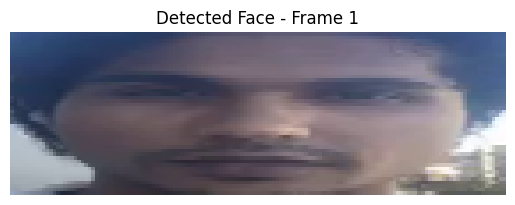

Total faces detected: 78


In [104]:
import cv2
from deepface import DeepFace
import matplotlib.pyplot as plt

def extract_faces_and_display_faces(video_path, display_count=1):
    """
    Extract faces from a video and display the first `display_count` detected faces using matplotlib.

    Args:
        video_path: Path to the input video file.
        display_count: Number of faces to display.

    Returns:
        List of cropped face frames.
    """
    cap = cv2.VideoCapture(video_path)
    processed_faces = []
    frame_number = 0
    displayed_faces = 0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        frame_number += 1
        try:
            # Use DeepFace to extract faces
            face_details = DeepFace.extract_faces(img_path=frame, enforce_detection=False)

            for detail in face_details:
                # Extract the cropped face
                face = detail["face"]

                # Resize the face manually if needed
                face_resized = cv2.resize(face, (140, 46))  # (width, height)
                processed_faces.append(face_resized)

                # Display the face using matplotlib
                if displayed_faces < display_count:
                    plt.imshow(face_resized, cmap="gray")
                    plt.title(f"Detected Face - Frame {frame_number}")
                    plt.axis("off")
                    plt.show()
                    displayed_faces += 1

        except Exception as e:
            print(f"Face detection failed for frame {frame_number}: {str(e)}")

    cap.release()
    return processed_faces

# Use the function
video_path = "/content/ashick_3secs_outdoor.mp4"
detected_faces = extract_faces_and_display_faces(video_path)

print(f"Total faces detected: {len(detected_faces)}")


In [ ]:
# things to do...integrate deepface into the pipeline..
# experiment with LLM-check starred repo.